In [1]:
import os.path as osp
import os

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.datasets import JODIEDataset
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TransformerConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
__file__ = os.path.abspath('')
path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'JODIE')

# TemporalData(src=[157474], dst=[157474], t=[157474], msg=[157474, 172], y=[157474])
dataset = JODIEDataset(path, name='reddit')
data_orig = dataset[0]

In [2]:
len(data_orig.dst)

672447

In [3]:
data_orig.dst

tensor([10000, 10001, 10002,  ..., 10129, 10008, 10119])

In [4]:
from torch_geometric.data import Data
 
data = Data(x=data_orig.msg, edge_index=torch.stack([data_orig.src, data_orig.dst], dim=0), edge_attr=data_orig.t)

In [5]:
data.num_nodes

672447

In [6]:
from collections import OrderedDict
 
class LRUCache:
    def __init__(self, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity
        self.stats = []
 
    def get(self, key: int) -> int:
        if key not in self.cache:
            self.stats.append(0)
            return -1
        else:
            self.stats.append(1)
            self.cache.move_to_end(key)
            return self.cache[key]
 
    def put(self, key: int, value: int) -> None:
        self.cache[key] = value
        self.cache.move_to_end(key)
        if len(self.cache) > self.capacity:
            self.cache.popitem(last = False)

In [7]:
import os.path as osp
import os
import torch
from overflowDataset import OpenFlowDataset
from tqdm import tqdm
from neighbor_sampler import NeighborSampler

In [8]:


total_nodes = torch.unique(data.edge_index[0]).numel() + torch.unique(data.edge_index[1]).numel()

subset = int(data.num_nodes)
# Assume CPU cache is 10% of data
CPUCacheNum = int(total_nodes / 10)

# Assume GPU cache is 0.25% of data
GPUCacheNum = int(total_nodes / 200)
node_ids = torch.flatten(data.edge_index.t())

CPUCacheLRU  = LRUCache(CPUCacheNum)
GPUCache = LRUCache(GPUCacheNum)

temp_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=node_ids, batch_size=2)

pbar = tqdm(total=subset*2)
for batch_size, ids, adjs in temp_loader:
  for i in ids:
    i = int(i)
    val = CPUCacheLRU.get(i)
    if (val == -1):
      # Fetch from SSD
      CPUCacheLRU.put(i,i)
  pbar.update(batch_size)
pbar.close()

100%|██████████| 1344894/1344894 [01:57<00:00, 11425.09it/s]


In [9]:
def sum_intervals(vals):
    interval_size = 5000
    num_intervals = len(vals) // interval_size
    interval_sums = []
    for i in range(num_intervals):
        start_index = i * interval_size
        end_index = start_index + interval_size
        interval = vals[start_index:end_index]
        interval_sum = sum(interval) / interval_size
        interval_sums.append(interval_sum)
    return interval_sums

def getHitRate(stats):
    return sum(stats)/len(stats)

In [10]:
stats = list(CPUCacheLRU.stats)
intervals_dynamic = sum_intervals(stats)
getHitRate(intervals_dynamic)

0.23468502894954515

(0.0, 0.5)

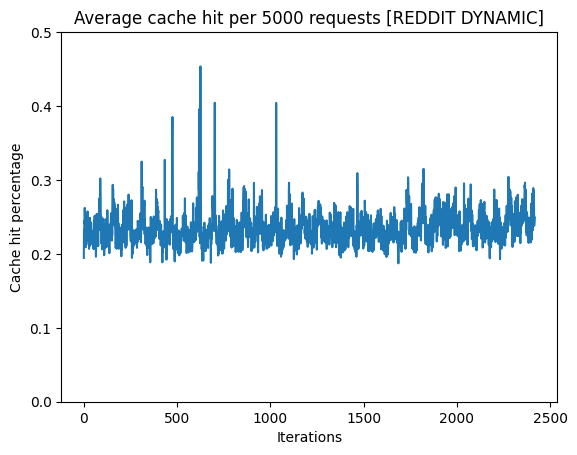

In [23]:
import matplotlib.pyplot as plt

plt.plot(intervals_dynamic)
plt.title('Average cache hit per 5000 requests [REDDIT DYNAMIC]')
plt.ylabel('Cache hit percentage')
plt.xlabel('Iterations')
plt.ylim([0,0.5])

In [12]:
# STATIC CACHE

import scipy
import numpy as np

coo = data.edge_index.numpy()
v = np.ones_like(coo[0])
coo = scipy.sparse.coo_matrix((v, (coo[0], coo[1])), shape=(data.num_nodes, data.num_nodes))
csc = coo.tocsc()
csr = coo.tocsr()

csc_indptr_tensor = torch.from_numpy(csc.indptr.astype(np.int64))
csr_indptr_tensor = torch.from_numpy(csr.indptr.astype(np.int64))
out_num_neighbors = csr_indptr_tensor[1:] - csr_indptr_tensor[:-1]
in_num_neighbors = (csc_indptr_tensor[1:] - csc_indptr_tensor[:-1])

sorted_vals_out, indices_out = torch.sort(out_num_neighbors, descending=True)
sorted_vals_in, indices_in = torch.sort(in_num_neighbors, descending=True)

In [13]:
print(sorted_vals_out.numel())
print(torch.count_nonzero(sorted_vals_out))
print(indices_in)

672447
tensor(10000)
tensor([ 10032,  10019,  10072,  ..., 224809, 224810, 224811])


In [14]:
# Sanity check in/out neighbours correct

nds = torch.tensor([10032, 10019], dtype=torch.long)
temp_loader = NeighborSampler(data.edge_index, sizes=[-1], node_idx=nds, batch_size=1)
for batch_size, ids, adjs in temp_loader:
    print(ids.size())

torch.Size([2556])
torch.Size([1567])


In [15]:
total_nodes

10984

In [16]:
subset = int(data.num_nodes)
node_ids = torch.flatten(data.edge_index.t())

# Assume CPU cache is 10% of data
CPUCacheNum = int(total_nodes / 10)

# Assume GPU cache is 0.25% of data
GPUCacheNum = int(total_nodes / 200)

CPUCacheStatic  = LRUCache(CPUCacheNum)
GPUCache = LRUCache(GPUCacheNum)

# Populate cache with highest out degree nodes
for i in range(CPUCacheNum):
    val = int(indices_out[i])
    CPUCacheStatic.put(val, val)

In [17]:
temp_loader = NeighborSampler(data.edge_index, sizes=[10,10], node_idx=node_ids, batch_size=2)

pbar = tqdm(total=subset*2)
for batch_size, ids, adjs in temp_loader:
  for i in ids:
    i = int(i)
    val = CPUCacheStatic.get(i)
  pbar.update(batch_size)
pbar.close()

100%|██████████| 1344894/1344894 [01:50<00:00, 12180.52it/s]


In [18]:
stats = list(CPUCacheStatic.stats)
intervals_static = sum_intervals(stats)
getHitRate(intervals_static)

0.16641629445823028

(0.0, 0.5)

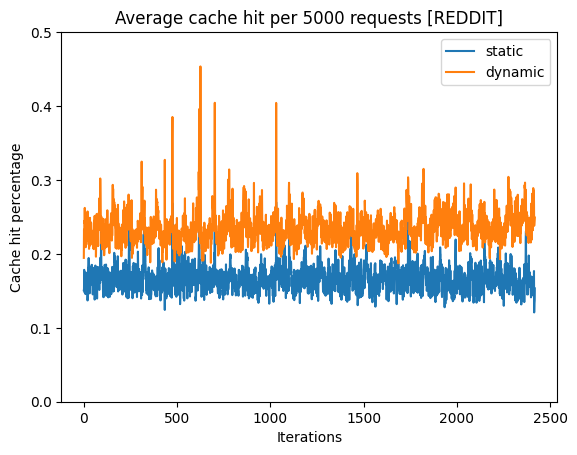

In [24]:
import matplotlib.pyplot as plt

plt.plot(intervals_static, label="static")
plt.plot(intervals_dynamic, label="dynamic")
plt.legend()
plt.title('Average cache hit per 5000 requests [REDDIT]')
plt.ylabel('Cache hit percentage')
plt.xlabel('Iterations')
plt.ylim([0,0.5])